In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint

In [4]:
def DiscreteRV_MutualInfo(rv):#def MutualInfo(rv):
    numRV = rv.shape[0]
    RVsize = rv.shape[1]
    histRV = np.array(np.unique(rv[0], axis=0, return_counts=True)[1])[None,:]
    histRV2 = np.array(np.unique(rv[(0,1),:], axis=1, return_counts=True)[1])[None,:]
    for i in range(1, numRV):
        histRV = np.append(histRV, np.array(np.unique(rv[i], axis=0, return_counts=True)[1])[None,:], axis=0)
        if i!=1:
            for j in range(i):
                newArr = np.unique(rv[(j,i),:], axis=1, return_counts=True)
                histRV2 = np.append(histRV2, np.array(newArr[1])[None,:], axis=0)
    pmfRV = histRV/RVsize
    pmfRV2 = histRV2/RVsize
    H = -1*np.average(np.log(pmfRV), weights=pmfRV, axis=1)
    H2 = -1*np.average(np.log(pmfRV2), weights=pmfRV2, axis=1)
    MI = np.zeros(H2.shape)
    index = 0
    for i in range(1, numRV):
        for j in range(i):
            MI[index] = H2[index] - H[i] - H[j]
            index = index + 1
    return MI

def DiscreteEntropy(y):
    #cols = y.shape[y.ndim-1]
    #rows = y.shape[0]
    pmf = np.unique(y, return_counts=True, axis=y.ndim-1)[1]/y.shape[y.ndim-1]
    return -1*np.average(np.log(pmf), weights=pmf)

In [5]:
from scipy.special import comb
def subset(size, index):
    subset = [-1]
    sum = 0
    for numOutput in range(size + 1):
        c = comb(size, numOutput)
        if index >= sum + c:
            sum += c
        else:
            break
    #print (numOutput)
    numLeft = numOutput
    for candidate in range(size-1, -1, -1):
        if index == sum:
            for remaining in range(numLeft-1, -1, -1):
                if subset[0] == -1:
                    subset[0] = remaining
                else:
                    subset = np.append(subset, remaining)
            break
        elif 0 == numLeft:
            break
        elif (index - sum) >= comb(candidate, numLeft):
            sum += comb(candidate, numLeft)
            if subset[0] == -1:
                subset[0] = candidate
            else:
                subset = np.append(subset, candidate)
            numLeft -= 1
    #print(output)
    if subset[0] != -1:
        return subset

def subsetIndex(size, subset):
    index = 0
    if np.all(subset) != None:
        subset = np.array(subset)
        numSubset = subset.size
        for i in range(numSubset):
            index += comb(size, i)
        sorted = np.sort(subset)
        for i in range(numSubset - 1, -1, -1):
            if sorted[i] > i:
                index += comb(sorted[i], i + 1)
    return index
            
def TestSubsetAndIndex(size):
    pow = 2**size
    print ("Test Subset with size=", size, " and pow=", pow)
    for i in range(pow):
        set = subset(size, i)
        print(i, "\t", subsetIndex(size, set), "\t", set)

def ConditionSet(size, Resp, index):
    set = subset(size - 1, index)
    cond = [-1]
    for element in set:
        if element >= Resp:
            element += 1
        if cond[0] == -1:
            cond[0] = element
        else:
            cond = np.append(cond, element)
    return cond

def ConditionIndex(size, Resp, cond):
    if (np.ma.is_masked(cond)):
        condSet = []
        for i in range(cond.size):
            if cond.mask[i] == False:
                if cond[i] > Resp:
                    condSet.append(cond[i] - 1)
                else:
                    condSet.append(cond[i])
        condSet = np.array(condSet)
        sizeUnmasked = size - np.ma.count_masked(cond)
        indexInResp = subsetIndex(sizeUnmasked, condSet)
    else:
        condSet = np.zeros(cond.shape)
        for i in range(condSet.size):
            if cond[i] > Resp:
                condSet[i] = cond[i] - 1
            else:
                condSet[i] = cond[i]
        indexInResp = subsetIndex(size, condSet)
    return indexInResp

In [6]:
#from scipy.special import softmax
def NegLogLikeScorer_Softmax(estimator, X, y):
    y_est = estimator.predict_proba(X)
    y_exp = np.exp(y_est)
    y_sum = np.sum(y_exp, axis=1)
    sm_est = y_exp/np.broadcast_to(y_sum[:,None],y_exp.shape)
    #sm_est = softmax(y_est, axis=1)
    y_like, count = np.unique(sm_est[np.arange(y.size), y], return_counts=True)
    if 0 == y.size:
        return -1
    #ignore 0 likelihood
    if 0 == y_like[0]:
        nom = -1*np.average(np.log(y_like[1:]), weights=count[1:])
        if 1 == y.size:
            return 0
    else:
        nom = -1*np.average(np.log(y_like), weights=count)
    return nom/y.size

def NegLogLikeScorer(estimator, X, y):
    y_est = estimator.predict_proba(X)
    y_like, count = np.unique(y_est[np.arange(y.size), y], return_counts=True)
    if 0 == y.size:
        return -1
    #ignore 0 likelihood
    if 0 == y_like[0]:
        nom = -1*np.average(np.log(y_like[1:]), weights=count[1:])
        if 1 == y.size:
            return 0
    else:
        nom = -1*np.average(np.log(y_like), weights=count)
    return nom/y.size

def CondDEntropyScorer(estimator, X, y):
    y_est = estimator.predict(X)
    #print (np.unique(np.array([y,y_est]), return_counts=True, axis=1))
    return DiscreteEntropy(np.array([y,y_est])) - DiscreteEntropy(y_est)
from sklearn.model_selection import cross_val_score
#print (cross_val_score(clf,np.transpose(rv[ConditionSet(numRV, 0, 6)]), rv[0], cv=3, scoring=CondEntropyScorer))


def computeEnt(rv, clf, scorer, entropy, CV_Fold, verbose=False):
    num_RV = rv.shape[0]
    _high = np.amax(rv)
    _low = np.amin(rv)
    numComb = np.power(2, num_RV - 1)
    DEntropy = np.zeros((num_RV, numComb))
    if verbose:
        print (num_RV, " Discrete RVs with range [", _low, ", ", _high, "]")
        print ("Resp\tCond\tH(Resp|Cond)")
    for Resp in range(num_RV):
        DEntropy[Resp,0] = entropy(rv[Resp])
        for sI in range(1, numComb):
            DEntropy[Resp,sI] = np.mean(cross_val_score(clf,np.transpose(rv[ConditionSet(num_RV, Resp, sI)]), rv[Resp], cv=CV_Fold, scoring=scorer))
            if verbose:
                print (Resp, "\t", ConditionSet(num_RV, Resp, sI), "\t", DEntropy[Resp,sI])
    return DEntropy

def getRandomVar_select(method, low, high, RVsize, numRV, depend):
    rv = np.split(method(low, high, size=RVsize*(numRV - 1)), numRV - 1)
    rv_sel = np.array(rv)[depend]
    rv = np.append(rv, np.remainder(np.sum(rv_sel, axis=0), high)[None,:], axis=0)
    print (rv)
    return rv

def getRandomVar(method, low, high, RVsize, numRV):
    rv = np.split(method(low, high, size=RVsize*(numRV - 1)), numRV - 1)
    rv = np.append(rv, np.remainder(np.sum(rv, axis=0), high)[None,:], axis=0)
    return rv

In [30]:
def MMI(MI, index, depth=0, printAtDepth = 0):
    setSize = index.size - np.ma.count_masked(index)
    MI_set = 0
    k = 0
    if (setSize > 1):
        if (depth == printAtDepth):
            print ("MI[{0}] = 1/{1}*E(".format(index, setSize -1))
        for i in range(index.size):
            if (index.mask[i] == False):
                index.mask[i] = True
                ci = ConditionIndex(MI.shape[0], i, index) - 1
                MI_set += MI[i,int(ci)]
                if (depth == printAtDepth):
                    print("MI[{0},{1}] ".format(i,index), end = '')
                if (np.ma.count_masked(index) < index.size):
                    j_next = depth + 1
                    subMI = MMI(MI, index, j_next, printAtDepth)
                    MI_set += subMI*(setSize - 2)
                    if (depth == printAtDepth):
                        print("+ {0}*MI[{1}]".format(setSize-2, index), end='')
                index.mask[i] = False
                k += 1
                if (k < setSize):
                    if (depth == printAtDepth):
                        print(" , ")
                else:
                    if (depth == printAtDepth):
                        print("")
                    break
        MI_set /= (setSize - 1)
        MI_set /= setSize
        if (depth == printAtDepth):
            print (") = {0}".format(MI_set))
    return MI_set

def CondEnt2MMI(MMI, CondEnt):
    MI = np.broadcast_to(CondEnt[:,0][:,None], CondEnt[:,1:].shape) - CondEnt[:,1:]
    index = np.ma.array(np.arange(numRV), mask=False)
    depth = 0
    return MMI(index, depth, MI)

In [17]:
from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors


def Ent_knn(X, k=6):
    if 1 == X.ndim:
        X = X[:,None]
    else:
        X = np.transpose(X)
    #print(X)
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    d, _ = knn.kneighbors(X)
    r = d[:,-1]
    #print ("X.ndim={0} r = {1}".format(X.ndim, d))
    n, d = X.shape
    volume_unit_ball = (pi**(.5*d)) / gamma(.5*d + 1)
    
    return (d*np.mean(np.log(r + np.finfo(X.dtype).eps))
            + np.log(volume_unit_ball) + psi(n) - psi(k))

def MI_knn(X, resp, cond):
    return (Ent_knn(X[resp]) + Ent_knn(X[cond]) - Ent_knn(X))

def MI_Unsuperwise(X, scorer):
    num_RV = X.shape[0]
    #print ("X shape = {0}".format(num_RV))
    numMIperRV = np.power(2, num_RV - 1)
    MI = np.zeros((num_RV, numMIperRV-1))
    for Resp in range(num_RV):
        for sI in range(1, numMIperRV):
            MI[Resp, sI-1] = scorer(X, Resp, ConditionSet(num_RV,Resp,sI))
    return MI

In [36]:
import MINE
def MI_MINE(X, scorer):
    num_RV = X.shape[0]
    #print ("X shape = {0}".format(num_RV))
    numMIperRV = np.power(2, num_RV - 1)
    MI = np.zeros((num_RV, numMIperRV-1))
    for Resp in range(num_RV):
        for sI in range(1, numMIperRV):
            MI[Resp, sI-1] = scorer(X, Resp, ConditionSet(num_RV,Resp,sI))
    return MI

[9/1000] train_loss: 0.00010584408883005381 valid_loss: 0.00016946925243246369
Validation loss increased (inf --> 0.00016946925243246369).  Saving model ...
[9/1000] train_loss: -1.563712430652231e-06 valid_loss: -3.013294190168381e-07
Validation loss increased (inf --> -3.013294190168381e-07).  Saving model ...
[9/1000] train_loss: 0.00016605891669314589 valid_loss: 0.00027143148763570936
Validation loss increased (inf --> 0.00027143148763570936).  Saving model ...
[9/1000] train_loss: 8.281128521048231e-05 valid_loss: 0.00013574363547377288
Validation loss increased (inf --> 0.00013574363547377288).  Saving model ...
[9/1000] train_loss: 0.00025153031238005495 valid_loss: 0.00027275676184217444
Validation loss increased (inf --> 0.00027275676184217444).  Saving model ...
[9/1000] train_loss: 0.0001815161100239493 valid_loss: 0.00023599704945809208
Validation loss increased (inf --> 0.00023599704945809208).  Saving model ...
[9/1000] train_loss: 0.00012717774516204372 valid_loss: 0.00

KeyboardInterrupt: 

[29/1000] train_loss: 0.007821048167534173 valid_loss: 0.009699160978198052
Validation loss increased (0.0020805983163882046 --> 0.009699160978198052).  Saving model ...


In [ ]:
if __name__ == "__main__":
    #TestSubsetAndIndex(6)
    #ground truth

    # low, high, RVsize, numRV = 0, 2, 1000, 6
    # depend = np.array([0, 1, 2])
    # rv = getRandomVar_select(randint.rvs, low, high, RVsize, numRV, depend)

    # from sklearn import neighbors
    # numNeighbors = high
    # clf = neighbors.KNeighborsClassifier(numNeighbors)

    # CVFold = 3
    # computeEnt(rv, clf, CondDEntropyScorer, DiscreteEntropy, CVFold)

#     numRV = 6
#     index = np.ma.array(np.arange(numRV), mask=False)
#     for i in range(numRV):
#         index.mask[i] = True
#         print("CondIndex[{0},{1}]={2}".format(i,index,ConditionIndex(numRV, i, index)))
#         #print (index.shape)
#         index.mask[i] = False

In [34]:
    from sklearn.linear_model import LinearRegression
    linReg = LinearRegression()
    CVFold = 3
    KNN = []
    LinReg2 = []
    GT2 = []
    #COV2 = []
    #for i in range(1, 16):
    #    cov = 1 - 0.1**
    #    COV2.append(cov)i
    COV2 = np.linspace(0, 0.7, 5)
    for cov in COV2:
        Gaussian_cov3 = [[1,0,cov],[0,1,cov],[cov,cov,1]]
        mean3 = [0,0,0]
        Gaussian_cov2 = [[1,cov],[cov,1]]
        mean2 = [0,0]
        x = np.transpose(np.random.multivariate_normal( mean=mean3,
                                      cov=Gaussian_cov3,
                                     size = 300))
#         DE = computeEnt(x, linReg, MSEscorer, varEntropy, CVFold)
#         numVar = DE.shape[0]
#         MI = DE[1,0] + DE[0,0] - DE[0,1] - DE[1,1]
#         MI = MI/3
#         LinReg2.append(MI)

        #groundTruth = -0.5*np.log(1-cov*cov)
        groundTruth = -0.5*np.log(np.linalg.det(np.array(Gaussian_cov2)))
        GT2.append(groundTruth)


        MI_knn0 = MI_Unsuperwise(x, MI_knn)
        print(MI_knn0)
        index = np.ma.array(np.arange(MI_knn0.shape[0]), mask=False)
        print(MMI(MI_knn0, index, printAtDepth=-1))
        KNN.append(MMI(MI_knn0, index, printAtDepth=-1))
        #KNN.append(np.mean(MI_knn0))

[[-1.59247346 -1.47691627 -0.16963678]
 [-1.59247346 -1.51076951 -0.14018042]
 [-1.47691627 -1.51076951 -0.09922049]]
-0.8315328202851505
[[-1.57231276 -1.56020574 -0.12930505]
 [-1.57231276 -1.53360006 -0.19835595]
 [-1.56020574 -1.53360006 -0.18130884]]
-0.8625147325694318
[[-1.47597988 -1.33935274 -0.14558253]
 [-1.47597988 -1.47599548 -0.10121037]
 [-1.33935274 -1.47599548 -0.0199976 ]]
-0.759686434281012
[[-1.25550052 -1.17749064 -0.03694538]
 [-1.25550052 -1.23324992 -0.03416973]
 [-1.17749064 -1.23324992  0.20544534]]
-0.5886518081514407
[[-0.05846194  0.013765    1.03615781]
 [-0.05846194 -0.0169206   0.92383631]
 [ 0.013765   -0.0169206   1.42299929]]
0.5535626450537301


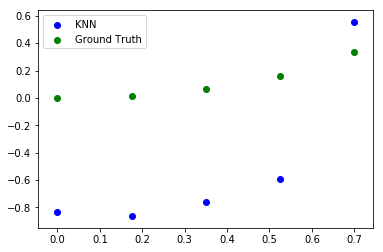

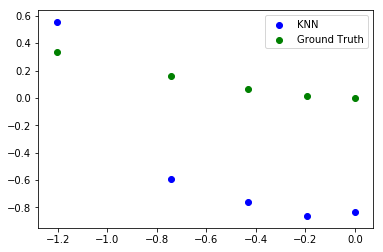

In [35]:
fig, ax = plt.subplots()

ax.scatter(COV2, KNN, c='b', label='KNN')
#ax.scatter(COV2, LinReg2, c='r', label='Regressor')
ax.scatter(COV2, GT2, c='g', label='Ground Truth')

ax.legend()
plt.show()

fig2, ax2 = plt.subplots()
COV22 = np.log(np.ones(len(COV2)) - COV2)
ax2.scatter(COV22, KNN, c='b', label='KNN')
#ax2.scatter(COV22, LinReg2, c='r', label='Regressor')
ax2.scatter(COV22, GT2, c='g', label='Ground Truth')

ax2.legend()
plt.show()